### This Notebook is all about point processes. Throughout this sheet i will slowly increase the complexity of analysis of point processes. The datasets used are synthetic datasets of patients and their visits to the hospital. I will start with a simple survival model of an event happening once (the second doctors visit). I will then consider a process with events that can happen multiple times. Finally I will also be considering covariates that vary with time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def prepend_print(df):
    s = str(df)
    lines = s.splitlines()
    print("# "+"\n# ".join(lines))

#  Load and visualize the data

Load the entire synthetic data of patients info.
Create a scatterplot of the point process data for the first 10 customers ($\leq$ 10).
Plot the patient id on the y-axis and time on the x-axis. Plot a dot whenever that patients visits the doctor.

In [6]:
visits_large = pd.read_csv("visits.csv")
patients_large = pd.read_csv("patients.csv")

In [9]:
# small dataset used for demo
patients_small = patients_large.head(10)
df_time_small = visits_large[visits_large.patient <10]

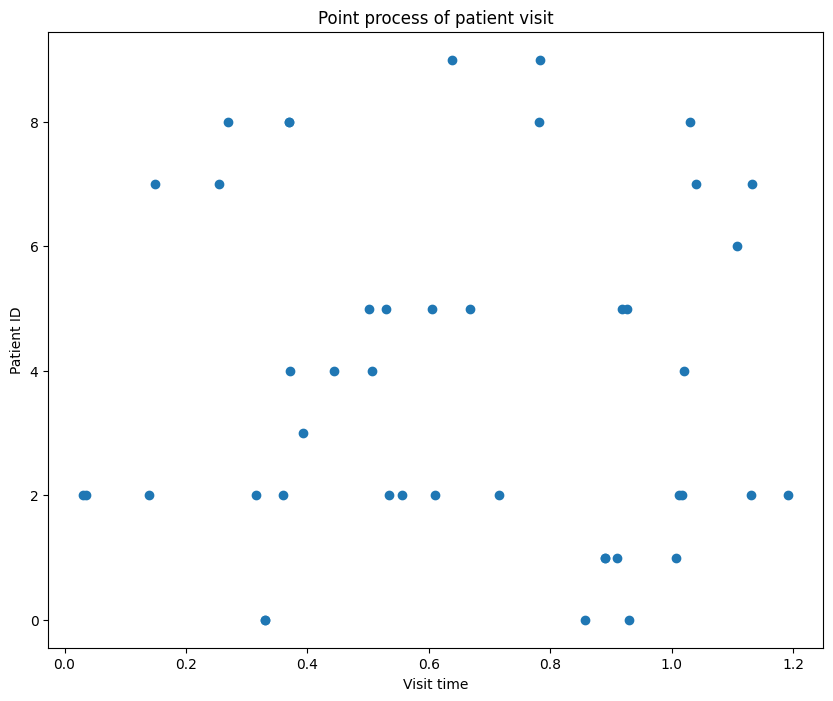

In [10]:
fig1 = plt.figure(figsize=(10,8))
plt.title("Point process of patient visit")
plt.xlabel("Visit time")
plt.ylabel("Patient ID")
plt.scatter(df_time_small["time"], df_time_small["patient"])

# The importance of accounting for censoring

I am interested in investigating the time between the first and the second doctors visit.
For this task, I  investigate the data up until certain timepoints [0.1, 0.2, ... 1.2]. This means that in the first observation period only data with times less or equal to 0.1 ($\leq$) are available. For second period data less than 0.2 is available and so on, increasing by 0.1 for each step up until 1.2.


##  Preparing the data

Write a function `prepare_analysis` that extracts the time of the first and second visit. Thereby I consider only data with time up to and including the threshold `t`.
Patients which did not have their first visit within the considered interval are not included. Otherwise, if the second visit is not in the interval, indicate this with a NaN value.








In [12]:
#pip install lifelines

In [13]:
from lifelines import ExponentialFitter

In [14]:
def prepare_analysis(df_time : pd.DataFrame, t : float) -> pd.DataFrame:

    def filter_func(x):
        return x["time"] <= t

    #sort patient and time
    sorted_data = df_time.sort_values(["patient", "time"])

    #apply filter function
    filtere_d = sorted_data.groupby(["patient", "time"]).filter(filter_func)

    #reset index
    filtere_d = filtere_d.reset_index()

    #find both first and second times
    first_time = filtere_d.groupby("patient", group_keys = False)["time"].nth([0])
    second_time = filtere_d.groupby("patient", group_keys = False)["time"].nth([1])

    #reset indexes for merging
    d_frame_1 = first_time.reset_index()
    d_frame_2 = second_time.reset_index()

    #merge both dataframes
    merged = pd.merge(d_frame_1, d_frame_2, on= "patient", how = "outer")

    #develop result dataframe

    return pd.DataFrame({"first" : merged["time_x"], "second" :  merged["time_y"]}).set_index(merged['patient'])

In [16]:
df01 = prepare_analysis(df_time_small, 0.1)
prepend_print(df01)


#            first    second
# patient                   
# 2        0.03105  0.034792


In [17]:
df02 = prepare_analysis(df_time_small, 0.2)
prepend_print(df02)


#             first    second
# patient                    
# 2        0.031050  0.034792
# 7        0.149173       NaN


In [18]:
df12 = prepare_analysis(df_time_small, 1.2)
prepend_print(df12)


#             first    second
# patient                    
# 0        0.329409  0.330142
# 1        0.890911  0.891027
# 2        0.031050  0.034792
# 3        0.392886       NaN
# 4        0.371249  0.443671
# 5        0.501808  0.530332
# 6        1.108256       NaN
# 7        0.149173  0.255098
# 8        0.269761  0.369204
# 9        0.637595  0.783621


##  Only observed ends

Implement a function `filter_b` which returns the time between first and second visit.

To calculate the survival analysis I need either a set duration or given times in which the the coxph package can calculate the hhazard estimation.


In [19]:
def filter_b(df : pd.DataFrame) -> pd.Series:

    #assuming the data is already prepared, we first drop all rows with NaN
    df = df.dropna()

    #find difference
    df = df["second"] - df["first"]

    return pd.Series(df)

In [20]:
filter_b(df01)


patient
2    0.003741
dtype: float64

In [21]:
filter_b(df02)


patient
2    0.003741
dtype: float64

##  Accounting for right censoring
In this approach, I keep information on patients whose first visit is in the considered interval but the second visit is not. Naturally, this is in addition to keeping the info on patients which had both their first and second visit in the considered time period.


Thus I implement a function `filter_c` which performs this filtering and returns the time between first and second visit as well as a second argument which indicates whether the second visit was acutally observed. When the second visit was not observed in the considered time period it is assigned the end of the considered period (i.e. `t`).


In [22]:
def filter_c(df : pd.DataFrame, t : float) -> (pd.Series, pd.Series):

    #create true or false values
    df["observed"] = df["second"].notna()

    #fillna with threshold
    df = df.fillna(t)

    #find the difference
    df["duration"] = df["second"] - df["first"]

    #create dataframe
    df =  pd.DataFrame({"duration" : df["duration"], "observed" :  df["observed"]})
    df.index.name = 'patient'
    return df

In [23]:
prepend_print(filter_c(df01, 0.1))


#          duration  observed
# patient                    
# 2        0.003741      True


In [24]:
prepend_print(filter_c(df02, 0.2))



#          duration  observed
# patient                    
# 2        0.003741      True
# 7        0.050827     False


In [25]:
prepend_print(filter_c(df12, 1.2))


#          duration  observed
# patient                    
# 0        0.000733      True
# 1        0.000116      True
# 2        0.003741      True
# 3        0.807114     False
# 4        0.072422      True
# 5        0.028524      True
# 6        0.091744     False
# 7        0.105925      True
# 8        0.099443      True
# 9        0.146026      True




##  Stability of hazard estimation

For each of the thresholds `t in [0.1, 0.2, ... 1.2]` estimate the hazard $\lambda$ (accessible via `.lambda_`) using the `ExponentialFitter` from the `lifelines` library.



For the case considered here the `.fit` function of the the `ExponentialFitter` requires only 1 or 2 arguments. The first argument is the length of intervals until the observed event (or in this case, the timespan between two events).
The second optional argument is only needed when accounting for potential censoring. You can pass a 0-1 array with information on censoring as a second argument to the `.fit` function. 1s are indicating and observed end, and 0s indicating still waiting for the end. The end here is "second visit".

The hazard function is λ(t) = f(t)/S(t). It is the probability that the
person or machine or business dies in the next instant, given that it survived
to time t

In [26]:
#filter_b
fb_01 = filter_b(prepare_analysis(visits_large,0.1))
fb_02 = filter_b(prepare_analysis(visits_large,0.2))
fb_03 = filter_b(prepare_analysis(visits_large,0.3))
fb_04 = filter_b(prepare_analysis(visits_large,0.4))
fb_05 = filter_b(prepare_analysis(visits_large,0.5))
fb_06 = filter_b(prepare_analysis(visits_large,0.6))
fb_07 = filter_b(prepare_analysis(visits_large,0.7))
fb_08 = filter_b(prepare_analysis(visits_large,0.8))
fb_09 = filter_b(prepare_analysis(visits_large,0.9))
fb_10 = filter_b(prepare_analysis(visits_large,1.0))
fb_11 = filter_b(prepare_analysis(visits_large,1.1))
fb_12 = filter_b(prepare_analysis(visits_large,1.2))



In [28]:
#filter_c
fc_01 = filter_c(prepare_analysis(visits_large,0.1), 0.1)
fc_02 = filter_c(prepare_analysis(visits_large,0.2), 0.2)
fc_03 = filter_c(prepare_analysis(visits_large,0.3), 0.3)
fc_04 = filter_c(prepare_analysis(visits_large,0.4), 0.4)
fc_05 = filter_c(prepare_analysis(visits_large,0.5), 0.5)
fc_06 = filter_c(prepare_analysis(visits_large,0.6), 0.6)
fc_07 = filter_c(prepare_analysis(visits_large,0.7), 0.7)
fc_08 = filter_c(prepare_analysis(visits_large,0.8), 0.8)
fc_09 = filter_c(prepare_analysis(visits_large,0.9), 0.9)
fc_10 = filter_c(prepare_analysis(visits_large,1.0), 1.0)
fc_11 = filter_c(prepare_analysis(visits_large,1.1), 1.1)
fc_12 = filter_c(prepare_analysis(visits_large,1.2), 1.2)

In [31]:
#exponential fitter
exp = ExponentialFitter()

In [32]:
#lambda for filter b
fb_01_exp = exp.fit(fb_01).lambda_
fb_02_exp = exp.fit(fb_02).lambda_
fb_03_exp = exp.fit(fb_03).lambda_
fb_04_exp = exp.fit(fb_04).lambda_
fb_05_exp = exp.fit(fb_05).lambda_
fb_06_exp = exp.fit(fb_06).lambda_
fb_07_exp = exp.fit(fb_07).lambda_
fb_08_exp = exp.fit(fb_08).lambda_
fb_09_exp = exp.fit(fb_09).lambda_
fb_10_exp = exp.fit(fb_10).lambda_
fb_11_exp = exp.fit(fb_11).lambda_
fb_12_exp = exp.fit(fb_12).lambda_


In [33]:
#lambda for filter c
fc_01_exp = exp.fit(fc_01["duration"],fc_01["observed"]).lambda_
fc_02_exp = exp.fit(fc_02["duration"],fc_02["observed"]).lambda_
fc_03_exp = exp.fit(fc_03["duration"],fc_03["observed"]).lambda_
fc_04_exp = exp.fit(fc_04["duration"],fc_04["observed"]).lambda_
fc_05_exp = exp.fit(fc_05["duration"],fc_05["observed"]).lambda_
fc_06_exp = exp.fit(fc_06["duration"],fc_06["observed"]).lambda_
fc_07_exp = exp.fit(fc_07["duration"],fc_07["observed"]).lambda_
fc_08_exp = exp.fit(fc_08["duration"],fc_08["observed"]).lambda_
fc_09_exp = exp.fit(fc_09["duration"],fc_09["observed"]).lambda_
fc_10_exp = exp.fit(fc_10["duration"],fc_10["observed"]).lambda_
fc_11_exp = exp.fit(fc_11["duration"],fc_11["observed"]).lambda_
fc_12_exp = exp.fit(fc_12["duration"],fc_12["observed"]).lambda_

##  Impact of covariates on the time between first and second visit

I now want to investigate the impact of covariates on the time between first and second visit.

To that I extend and  create a DataFrame `df_e` with columns `['duration', 'observed', 'age', 'height', 'woman', 'weight']` by joining the patient data (`patients.csv`) with the data on duration between first and second visit obtained in the model from

Then I fit a CoxPH model using the `CoxPHFitter` from the lifelines library to the entire dataset. Censoring is indicated where is necessary.

In [35]:
visits_filtered = filter_c(prepare_analysis(visits_large, 1.2), 1.2)

In [36]:
visits_filtered = visits_filtered.reset_index()

In [ ]:
#patients_large

In [37]:
from lifelines import CoxPHFitter

In [38]:
df_e = pd.merge(visits_filtered, patients_large, left_index= True, right_index=True).set_index("patient")

In [39]:
df_e_small = df_e[df_e.index < 10]

In [40]:
cph_e = CoxPHFitter().fit(df_e, duration_col= "duration", event_col="observed")
cph_e
cph_e.print_summary()

<lifelines.CoxPHFitter: fitted with 954 total observations, 94 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 954
number of events observed = 860
   partial log-likelihood = -5162.86
         time fit was run = 2023-07-25 21:11:02 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
height     -0.38       0.68       0.30            -0.98             0.21                 0.37                 1.24
woman      -0.04       0.96       0.07            -0.18             0.10                 0.83                 1.10
weight      0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01

            cmp to     z    p   -log2(p)
covariate                               
age           0.00  1.45 0.15       2.75
height        0.00 -1.26 0.21       2.28
woman         0.00 -0.62 0.54       0.89
weight        0.00  1.57 0.12       3.09
---
Concordance = 0.52
Partial AIC = 10333.71
log-likelihood ratio test = 5.08 on 4 df
-log2(p) of ll-ratio test = 1.84

In [41]:
# give you an idea how the input to the fit should look like
prepend_print(df_e_small)


#          duration  observed  age    height  woman      weight
# patient                                                      
# 0        0.000733      True   45  1.356927      0   56.493105
# 1        0.000116      True   38  1.912660      0   65.265604
# 2        0.003741      True   34  1.959194      0  114.580135
# 3        0.807114     False   26  1.366445      1   39.048446
# 4        0.072422      True   27  1.218124      1   26.843019
# 5        0.028524      True   19  1.638106      0   69.084010
# 6        0.091744     False   20  1.427899      0   60.243845
# 7        0.105925      True   18  1.980142      0   86.770180
# 8        0.099443      True   23  1.928389      0   81.263253
# 9        0.146026      True   44  1.972465      0   80.431458


##  Time between doctors visits

So far I was only concerned with the time between the first and second doctors visit. I will now be using the entire dataset to predict the time between doctors visits. (not just the time between the first and second). This is a little bit of an unsual scenario for survival analysis as each individual can experience the event more than once, but the methods used to analyse this problem are very similar to the once already explored.

Now I will write a function that computes the duration between all doctors visits for each patient. Notice, that for all of the patients their final visit is not recorded. Thus, I indicate this using an observed column which contains ones if durations true end was observed or whether the end is just the end of the investigation period.

In [42]:
from lifelines import CoxPHFitter

In [43]:
def prepare_analysis_all(df_time : pd.DataFrame, max_t : float) -> pd.DataFrame:
    def filter_funclong(x):
        return x["time"] <= max_t

    #sort dataframe
    sorted_all = df_time.sort_values(["patient", "time"])

    #apply filter function
    filtered_all = sorted_all.groupby(["patient", "time"]).filter(filter_funclong)

    #reset index
    filtered_all = filtered_all.reset_index()

    #create duration df
    filtered_all["duration"] = filtered_all.groupby("patient")["time"].diff(-1) * (-1)
    new_df = pd.DataFrame(filtered_all)
    new_df["observed"] = new_df["duration"].notna()
    values_nan = max_t - new_df["time"]
    new_df["duration"] = new_df["duration"].fillna(value=values_nan)

    #find the difference in durations
    return pd.DataFrame(new_df, columns = ["patient", "observed", "duration"])

In [44]:
visits_small = visits_large[visits_large["patient"]<= 10]
visits_large.time.min()

0.0007685788

In [45]:
durations_small = prepare_analysis_all(visits_small, 1.2)
prepend_print(durations_small.head(10))


#    patient  observed  duration
# 0        0      True  0.000733
# 1        0      True  0.526598
# 2        0      True  0.072540
# 3        0     False  0.270720
# 4        1      True  0.000116
# 5        1      True  0.019653
# 6        1      True  0.096634
# 7        1     False  0.192686
# 8        2      True  0.003741
# 9        2      True  0.104157


##  CoxPh for the entire dataset

Using the covariates in `patients.csv` in a CoxPH model but now modeling the entire dataset rather than the visits between the first and second visit only. To achieve this I perform a join.

Compute the parameter estimates once without (`cph_g1`) and once with (`cph_g2`) accounting for the fact that the observations are not independent. (rememember there are multiple observations for one patient)

*NB* You can indidate observations that belong to the same group through the keyword argument `cluster_col` of the `.fit` function.


In [46]:
all_filtered = prepare_analysis_all(visits_large,1.2)

In [47]:
df_g = pd.merge(all_filtered, patients_large, left_on='patient', right_index=True)

In [48]:
df_g_small = df_g[df_g["patient"]<=10]

In [49]:
cph_g1 = CoxPHFitter().fit(df_g, duration_col= "duration", event_col="observed")
cph_g1.print_summary()

<lifelines.CoxPHFitter: fitted with 4890 total observations, 954 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 4890
number of events observed = 3936
   partial log-likelihood = -29569.00
         time fit was run = 2023-07-25 21:22:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
patient     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
age         0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
height     -0.30       0.74       0.15            -0.59            -0.01                 0.56                 0.99
woman      -0.11       0.90       0.03            -0.18            -0.04                 0.84                 0.96
weight      0.02       1.02       0.00             0.02             0.03                 1.02                 1.03

            cmp to     z      p   -log2(p)
covariate                                 
patient       0.00  2.02   0.04       4.51
age           0.00  1.48   0.14       2.85
height        0.00 -2.03   0.04       4.57
woman         0.00 -3.21 <0.005       9.58
weight        0.00 15.61 <0.005     180.08
---
Concordance = 0.62
Partial AIC = 59148.00
log-likelihood ratio test = 662.21 on 5 df
-log2(p) of ll-ratio test = 465.53

In [50]:
cph_g1.params_

covariate
patient    0.000113
age        0.002534
height    -0.298400
woman     -0.109780
weight     0.022212
Name: coef, dtype: float64

In [51]:
#cluster column on patient
cph_g2 = CoxPHFitter().fit(df_g, duration_col= "duration", event_col="observed", cluster_col= 'patient')
cph_g2.print_summary()

<lifelines.CoxPHFitter: fitted with 4890 total observations, 954 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
              cluster col = 'patient'
          robust variance = True
      baseline estimation = breslow
   number of observations = 4890
number of events observed = 3936
   partial log-likelihood = -29571.03
         time fit was run = 2023-07-25 21:23:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
age         0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
height     -0.30       0.74       0.16            -0.61             0.01                 0.54                 1.01
woman      -0.11       0.89       0.03            -0.18            -0.04                 0.84                 0.96
weight      0.02       1.02       0.00             0.02             0.03                 1.02                 1.03

            cmp to     z      p   -log2(p)
covariate                                 
age           0.00  1.40   0.16       2.63
height        0.00 -1.91   0.06       4.15
woman         0.00 -3.22 <0.005       9.63
weight        0.00 14.60 <0.005     158.03
---
Concordance = 0.62
Partial AIC = 59150.07
log-likelihood ratio test = 658.14 on 4 df
-log2(p) of ll-ratio test = 466.38

In [52]:
cph_g2.params_

covariate
age       0.002547
height   -0.301391
woman    -0.111683
weight    0.022303
Name: coef, dtype: float64

In [53]:
# example for small dataset
prepend_print(df_g_small.head(10))



#    patient  observed  duration  age    height  woman      weight
# 0        0      True  0.000733   45  1.356927      0   56.493105
# 1        0      True  0.526598   45  1.356927      0   56.493105
# 2        0      True  0.072540   45  1.356927      0   56.493105
# 3        0     False  0.270720   45  1.356927      0   56.493105
# 4        1      True  0.000116   38  1.912660      0   65.265604
# 5        1      True  0.019653   38  1.912660      0   65.265604
# 6        1      True  0.096634   38  1.912660      0   65.265604
# 7        1     False  0.192686   38  1.912660      0   65.265604
# 8        2      True  0.003741   34  1.959194      0  114.580135
# 9        2      True  0.104157   34  1.959194      0  114.580135


In [54]:
observation_g = """
My observation is: A higher hazard means more risk of an event occuring. THe hazard ratio is the exponential of the
coefficients. For the CoxPH model of cph_g1 which has no cluster fit, The coefficients for the women and Weight were
0.90 and 1.02 respectively. This means the hazard ratio is high for these two factors. To practically explain, the
likelihood of a woman in a certain weight category to come back after the first visit is high. This is further supported
by the p values of both Weight and Woman which are <0.005. This means there is a statistically significant effect.

for cph_g2 which has cluster fit parameter, the coefficient of woman slightly drops to 0.89 but the co efficient
for weight remains constant. In this model however they still have significant effect on the hazard of visits as they
both have p values <0.005
"""

In [55]:
print(observation_g)


My observation is: A higher hazard means more risk of an event occuring. THe hazard ratio is the exponential of the
coefficients. For the CoxPH model of cph_g1 which has no cluster fit, The coefficients for the women and Weight were
0.90 and 1.02 respectively. This means the hazard ratio is high for these two factors. To practically explain, the
likelihood of a woman in a certain weight category to come back after the first visit is high. This is further supported
by the p values of both Weight and Woman which are <0.005. This means there is a statistically significant effect.

for cph_g2 which has cluster fit parameter, the coefficient of woman slightly drops to 0.89 but the co efficient
for weight remains constant. In this model however they still have significant effect on the hazard of visits as they
both have p values <0.005



## Time varying covariates

When looking at the data, you notice that the visits have an attached "type" property which indicates the kind of treatment that happened (0=diagnoses only, 1=treatment only, 2=diagnoses & treatment). Your common sense says that if a patient has been diagnosed but did not yet receive a treatment, he is more likely to return soon. So you hypothesize that `type=0` will strongly increase the hazard for that patient.


So far we have only looked at the case where the covariates are constant over the observation period. In order to account for the type of visit, this needs to change.

In `lifelines` time varying covariates are encoded using the "long" format (see [documentation](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html)). In the long format information is encoded in a start and stop time. During this timespan it is assumed, that the covariates are constant.


We thus need to encode our point process data in the long format (i.e. denote the start and stop) and We also associate each timespan with the type of the starting event. This is done in ther function `prepare_analysis_long`.
Then join this long format data with the patient information and fit a time varying CoxPH model (`cox_h`) to the data.



In [56]:
from lifelines import CoxTimeVaryingFitter

In [57]:
def prepare_analysis_long(df_time : pd.DataFrame, max_t : float) -> pd.DataFrame:
    def filter_analysislong(x):
        return x["time"] <= max_t

    #sort dataframe
    sorted_long = df_time.sort_values(["patient", "time"])

    #apply filter
    filtered_long = sorted_long.groupby(["patient", "time"]).filter(filter_analysislong)

    #reset index
    filtered_long = filtered_long.reset_index()

    #create df

    filtered_long["stop"] = filtered_long.groupby("patient")["time"].shift(-1)
    filtered_long["observed"] = filtered_long["stop"].notna()
    filtered_long["stop"] = filtered_long["stop"].fillna(max_t)
    filtered_long = filtered_long.rename(columns={'time': 'start'})


    return pd.DataFrame(filtered_long, columns=["patient", "start", "stop", "observed", "type"])

In [58]:
df_long_small = prepare_analysis_long(visits_small, 1.2)
prepend_print(df_long_small.head(10))


#    patient     start      stop  observed  type
# 0        0  0.329409  0.330142      True   2.0
# 1        0  0.330142  0.856740      True   2.0
# 2        0  0.856740  0.929280      True   0.0
# 3        0  0.929280  1.200000     False   1.0
# 4        1  0.890911  0.891027      True   0.0
# 5        1  0.891027  0.910681      True   1.0
# 6        1  0.910681  1.007314      True   0.0
# 7        1  1.007314  1.200000     False   1.0
# 8        2  0.031050  0.034792      True   2.0
# 9        2  0.034792  0.138949      True   2.0


In [60]:
all_fl_long = prepare_analysis_long(visits_large,1.2)
#all_fl_long

In [61]:
df_fit= pd.merge(all_fl_long, patients_large, left_on= "patient", right_index=True)


,patient,start,stop,observed,type,age,height,woman,weight
0,0,0.329409,0.330142,True,2.0,45,1.356927,0,56.493105
1,0,0.330142,0.856740,True,2.0,45,1.356927,0,56.493105
2,0,0.856740,0.929280,True,0.0,45,1.356927,0,56.493105
3,0,0.929280,1.200000,False,1.0,45,1.356927,0,56.493105
4,1,0.890911,0.891027,True,0.0,38,1.912660,0,65.265604
...,...,...,...,...,...,...,...,...,...
4885,997,0.984709,1.200000,False,1.0,31,1.946294,0,65.714050
4886,998,0.548957,0.970227,True,2.0,24,1.835519,0,67.069732
4887,998,0.970227,1.165781,True,2.0,24,1.835519,0,67.069732
4888,998,1.165781,1.200000,False,2.0,24,1.835519,0,67.069732


In [63]:
df_fit= pd.merge(all_fl_long, patients_large, left_on= "patient", right_index=True)


In [64]:
df_fit_small = df_fit[df_fit["patient"]<= 10]

In [65]:
prepend_print(df_fit_small.head(10))


#    patient     start      stop  observed  type  age    height  woman  \
# 0        0  0.329409  0.330142      True   2.0   45  1.356927      0   
# 1        0  0.330142  0.856740      True   2.0   45  1.356927      0   
# 2        0  0.856740  0.929280      True   0.0   45  1.356927      0   
# 3        0  0.929280  1.200000     False   1.0   45  1.356927      0   
# 4        1  0.890911  0.891027      True   0.0   38  1.912660      0   
# 5        1  0.891027  0.910681      True   1.0   38  1.912660      0   
# 6        1  0.910681  1.007314      True   0.0   38  1.912660      0   
# 7        1  1.007314  1.200000     False   1.0   38  1.912660      0   
# 8        2  0.031050  0.034792      True   2.0   34  1.959194      0   
# 9        2  0.034792  0.138949      True   2.0   34  1.959194      0   
# 
#        weight  
# 0   56.493105  
# 1   56.493105  
# 2   56.493105  
# 3   56.493105  
# 4   65.265604  
# 5   65.265604  
# 6   65.265604  
# 7   65.265604  
# 8  114.580135  
# 9

In [66]:
cox_h = CoxTimeVaryingFitter(penalizer=0.1)
cox_h.fit(df_fit, id_col= 'patient', event_col= 'observed', start_col = 'start', stop_col = 'stop', show_progress = True)

Iteration 1: norm_delta = 0.51718, step_size = 0.95000, ll = -26154.01084, newton_decrement = 568.28967, seconds_since_start = 2.9
Iteration 2: norm_delta = 0.04172, step_size = 0.95000, ll = -25621.10105, newton_decrement = 3.36910, seconds_since_start = 4.5
Iteration 3: norm_delta = 0.00252, step_size = 0.95000, ll = -25617.71596, newton_decrement = 0.01314, seconds_since_start = 6.7
Iteration 4: norm_delta = 0.00013, step_size = 1.00000, ll = -25617.70284, newton_decrement = 0.00003, seconds_since_start = 8.0
Iteration 5: norm_delta = 0.00000, step_size = 1.00000, ll = -25617.70281, newton_decrement = 0.00000, seconds_since_start = 9.2
Convergence completed after 5 iterations.


<lifelines.CoxTimeVaryingFitter: fitted with 4890 periods, 954 subjects, 3936 events>

In [67]:
cox_h.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 4890 periods, 954 subjects, 3936 events>
         event col = 'observed'
         penalizer = 0.1
number of subjects = 954
 number of periods = 4890
  number of events = 3936
partial log-likelihood = -25617.70
  time fit was run = 2023-07-25 21:35:25 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
type       -0.41       0.66       0.02            -0.45            -0.37                 0.64                 0.69
age         0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
height      0.21       1.24       0.11            -0.01             0.43                 0.99                 1.54
woman      -0.13       0.88       0.03            -0.19            -0.06                 0.83                 0.94
weight      0.02       1.02       0.00             0.02             0.02                 1.02                 1.02

            cmp to      z      p   -log2(p)
covariate                                  
type          0.00 -20.64 <0.005     311.90
age           0.00   1.31   0.19       2.40
height        0.00   1.88   0.06       4.07
woman         0.00  -3.94 <0.005      13.59
weight        0.00  15.85 <0.005     185.44
---
Partial AIC = 51245.41
log-likelihood ratio test = 1072.62 on 5 df
-log2(p) of ll-ratio test = 760.54

In [68]:
cox_h.params_

covariate
type     -0.413194
age       0.002126
height    0.211224
woman    -0.125867
weight    0.017158
dtype: float64

In [69]:
answer_h = """
Does the data support your hypothesis?

for the Coxvarying fitter model we can infer from the results that the type has a p value of <0.005 which is
statistically significant. This means our hypothesis whixh states that type = 0 will strongly increase the
hazard for that patient is true. In addition just like in previous models, The weight and the woman factor also
significantly affect the hazard for the patient.


"""

In [70]:
print(answer_h)


Does the data support your hypothesis?

for the Coxvarying fitter model we can infer from the results that the type has a p value of <0.005 which is
statistically significant. This means our hypothesis whixh states that type = 0 will strongly increase the
hazard for that patient is true. In addition just like in previous models, The weight and the woman factor also
significantly affect the hazard for the patient.





<Axes: xlabel='log(HR) (95% CI)'>

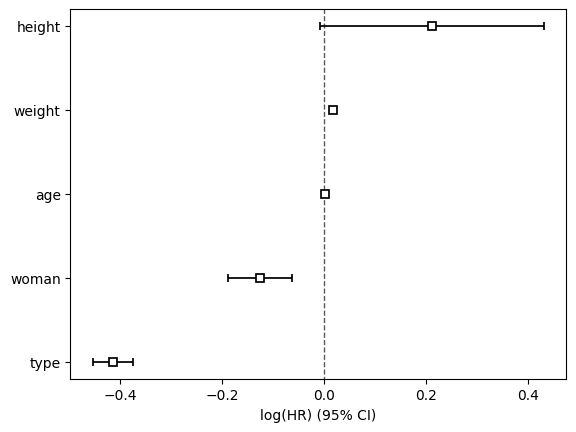

In [71]:
cox_h.plot()